<div style="padding:20px; font-size:250%; text-align:center; display:fill; border-radius:10px; background-color:#c0d6df">
    <b><span style="color:#2f3e46">Diabetes Prediction</span></b>
</div>

# <b><span style="color:#2f3e46">Introduction</span></b>

<p><span style="font-size: 16px">The purpose of this notebook is to investigate health-related factors and find correlations between them and diabetes, and thereby build a machine-learning model capable of classifying whether or not a patient has diabetes.</span></p>


The factors include:

- __Age:__ Age is an important factor in predicting diabetes risk. As individuals get older, their risk of developing diabetes increases. This is partly due to factors such as reduced physical activity, changes in hormone levels, and a higher likelihood of developing other health conditions that can contribute to diabetes.

- __Gender:__ Gender can play a role in diabetes risk, although the effect may vary. For example, women with a history of gestational diabetes (diabetes during pregnancy) have a higher risk of developing type 2 diabetes later in life. Additionally, some studies have suggested that men may have a slightly higher risk of diabetes compared to women.

- __Body Mass Index (BMI):__ BMI is a measure of body fat based on a person's height and weight. It is commonly used as an indicator of overall weight status and can be helpful in predicting diabetes risk. Higher BMI is associated with a greater likelihood of developing type 2 diabetes. Excess body fat, particularly around the waist, can lead to insulin resistance and impair the body's ability to regulate blood sugar levels.

- __Hypertension:__ Hypertension, or high blood pressure, is a condition that often coexists with diabetes. The two conditions share common risk factors and can contribute to each other's development. Having hypertension increases the risk of developing type 2 diabetes and vice versa. Both conditions can have detrimental effects on cardiovascular health.

- __Heart Disease:__ Heart disease, including conditions such as coronary artery disease and heart failure, is associated with an increased risk of diabetes. The relationship between heart disease and diabetes is bidirectional, meaning that having one condition increases the risk of developing the other. This is because they share many common risk factors, such as obesity, high blood pressure, and high cholesterol.

- __Smoking History:__ Smoking is a modifiable risk factor for diabetes. Cigarette smoking has been found to increase the risk of developing type 2 diabetes. Smoking can contribute to insulin resistance and impair glucose metabolism. Quitting smoking can significantly reduce the risk of developing diabetes and its complications.

- __HbA1c Level:__ HbA1c (glycated hemoglobin) is a measure of the average blood glucose level over the past 2-3 months. It provides information about long-term blood sugar control. Higher HbA1c levels indicate poorer glycemic control and are associated with an increased risk of developing diabetes and its complications.

- __Blood Glucose Level:__ Blood glucose level refers to the amount of glucose (sugar) present in the blood at a given time. Elevated blood glucose levels, particularly in the fasting state or after consuming carbohydrates, can indicate impaired glucose regulation and increase the risk of developing diabetes. Regular monitoring of blood glucose levels is important in the diagnosis and management of diabetes.

## <b><span style="color:#2f3e46">Libraries and settings</span></b>

In [70]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import warnings
import os

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix

# Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [71]:
%matplotlib inline

# Customize matplotlib
mpl.rc("axes", labelsize=12, titlesize=14)
mpl.rc("figure", figsize=(8, 4))

# Customize seaborn
sns.set_style("darkgrid")
sns.set_palette("muted")

# Ignore warnings
warnings.filterwarnings("ignore")

# Set the decimal format
pd.options.display.float_format = "{:.3f}".format

## <b><span style="color:#2f3e46">Import data</span></b>

In [72]:
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv


In [73]:
df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")
print("Dataset shape:", df.shape)
print("")
df.head()

Dataset shape: (100000, 9)



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.000,0,1,never,25.190,6.600,140,0
1,Female,54.000,0,0,No Info,27.320,6.600,80,0
2,Male,28.000,0,0,never,27.320,5.700,158,0
3,Female,36.000,0,0,current,23.450,5.000,155,0
4,Male,76.000,1,1,current,20.140,4.800,155,0


# <b><span style="color:#2f3e46">1 Exploratory Data Analysis</span></b>

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [75]:
df.duplicated().sum()

3854

There are a lot of duplicates. We can simply remove them.

In [76]:
df.drop_duplicates(inplace=True)

In [77]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

No missing values! It turns our job easier.

In [78]:
df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

Let's see that third gender and all unique values in <b>smoking_history</b>.

In [79]:
print(df["gender"].unique())
df["gender"].value_counts()

['Female' 'Male' 'Other']


Female    56161
Male      39967
Other        18
Name: gender, dtype: int64

In [80]:
df["smoking_history"].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

Since there are only 18 "Other", we can remove it. About <b>smoking_history</b>, we can condense all those categories into only three.

In [81]:
df = df.loc[df["gender"] != "Other"]

In [82]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.000,96128.000,96128.000,96128.000,96128.000,96128.000,96128.000
mean,41.797,0.078,0.041,27.321,5.533,138.218,0.088
std,22.463,0.268,0.198,6.768,1.073,40.911,0.284
min,0.080,0.000,0.000,10.010,3.500,80.000,0.000
25%,24.000,0.000,0.000,23.400,4.800,100.000,0.000
50%,43.000,0.000,0.000,27.320,5.800,140.000,0.000
75%,59.000,0.000,0.000,29.860,6.200,159.000,0.000
max,80.000,1.000,1.000,95.690,9.000,300.000,1.000


## <b><span style="color:#2f3e46">1.1 Numerical features</span></b>

Text(0.5, 0, 'Age (years)')

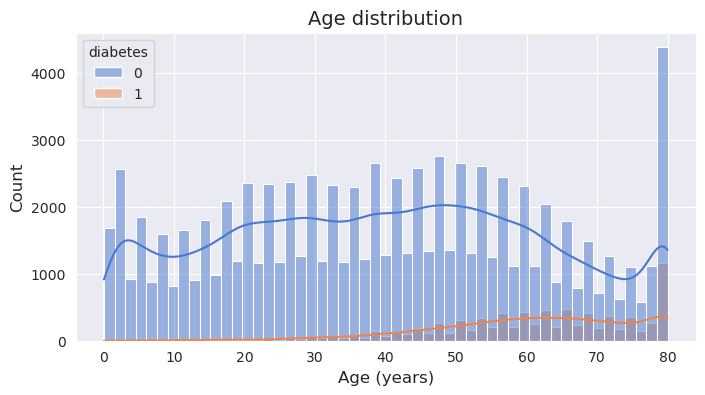

In [83]:
sns.histplot(data=df, x="age", hue="diabetes", kde=True)
plt.title("Age distribution")
plt.xlabel("Age (years)")

Elderly people are more likely to have diabetes.

(0.0, 1000.0)

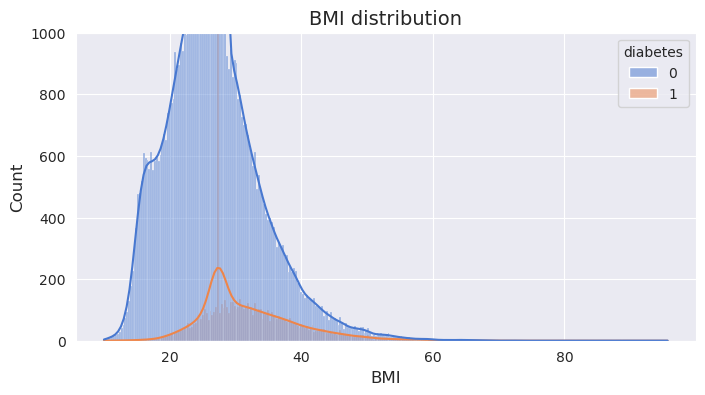

In [84]:
sns.histplot(data=df, x="bmi", hue="diabetes", kde=True)
plt.title("BMI distribution")
plt.xlabel("BMI")
plt.ylim(0,1000)

Notes:
- People with BMI greater than 20 are more likely to have diabetes
- The distribution is right-skewed but with a small number of outliers
- Apparently, a BMI of 27.32 is like a standard value, because it represents 23% of all values

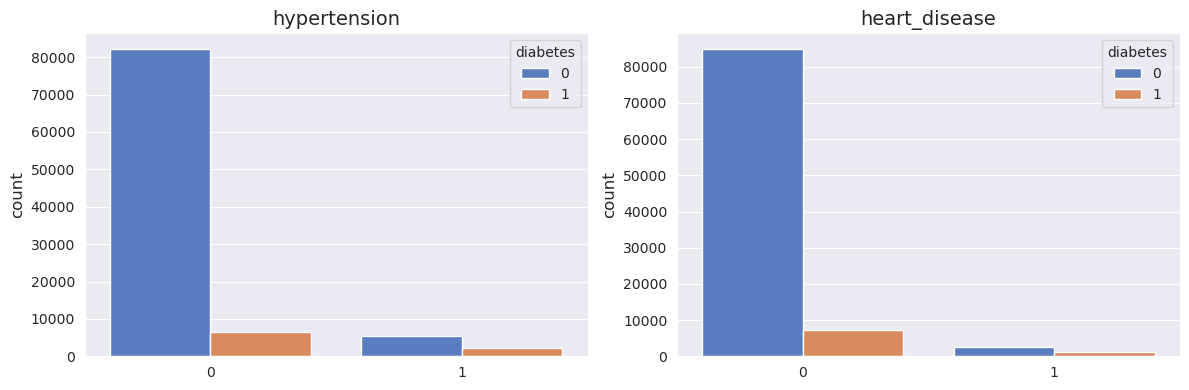

In [85]:
binary_features = ["hypertension", "heart_disease"]
fig = plt.figure(figsize=(12, 4))

for i, var_name in enumerate(binary_features):
    ax = fig.add_subplot(1, 2, 1*i+1)
    sns.countplot(data=df, x=var_name, hue="diabetes")
    ax.set_title(var_name)
    ax.set_xlabel("")
    
fig.tight_layout()

These features are quite imbalanced, so it might lead us to the wrong conclusion. We need to normalize them to analyze the distribution better.

In [86]:
# Group by and normalize
hypertension = (df.groupby(["hypertension", "diabetes"])["diabetes"].size() / df.groupby(["hypertension"]).size())
heart_disease = (df.groupby(["heart_disease", "diabetes"])["diabetes"].size() / df.groupby(["heart_disease"]).size())

# Create a dict and a DataFrame
heart_related = {"Hypertension_values": hypertension.values,
                 "Hypertension_status": hypertension.index.get_level_values(0),
                 "Heart disease_values": heart_disease.values,
                 "Heart disease_status": hypertension.index.get_level_values(0),
                 "Diabetes": [0, 1, 0, 1]}
heart_related_df = pd.DataFrame(heart_related)

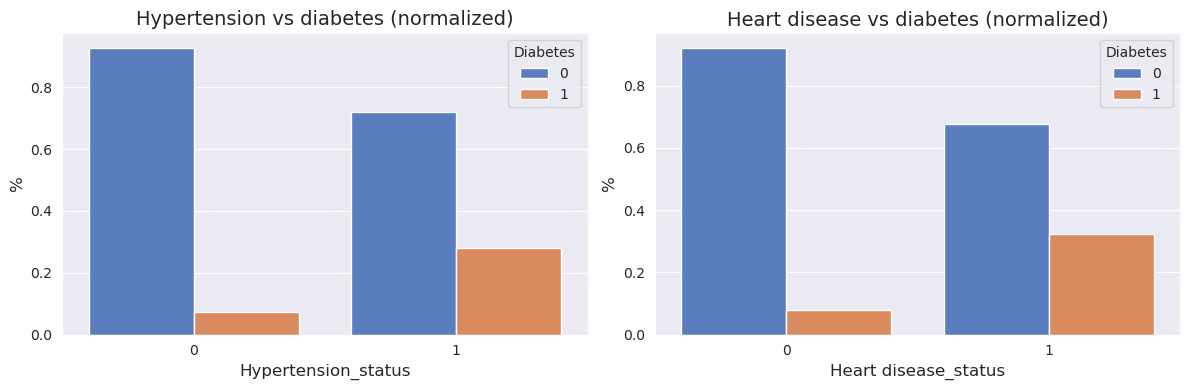

In [87]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.barplot(data=heart_related_df, x="Hypertension_status", y="Hypertension_values", hue="Diabetes")
plt.title("Hypertension vs diabetes (normalized)")
plt.ylabel("%")

plt.subplot(1, 2, 2)
sns.barplot(data=heart_related_df, x="Heart disease_status", y="Heart disease_values", hue="Diabetes")
plt.title("Heart disease vs diabetes (normalized)")
plt.ylabel("%")

fig.tight_layout()

Notes:
- People who are hypertensive are more likely to have diabetes
- People who have heart disease are more likely to have diabetes

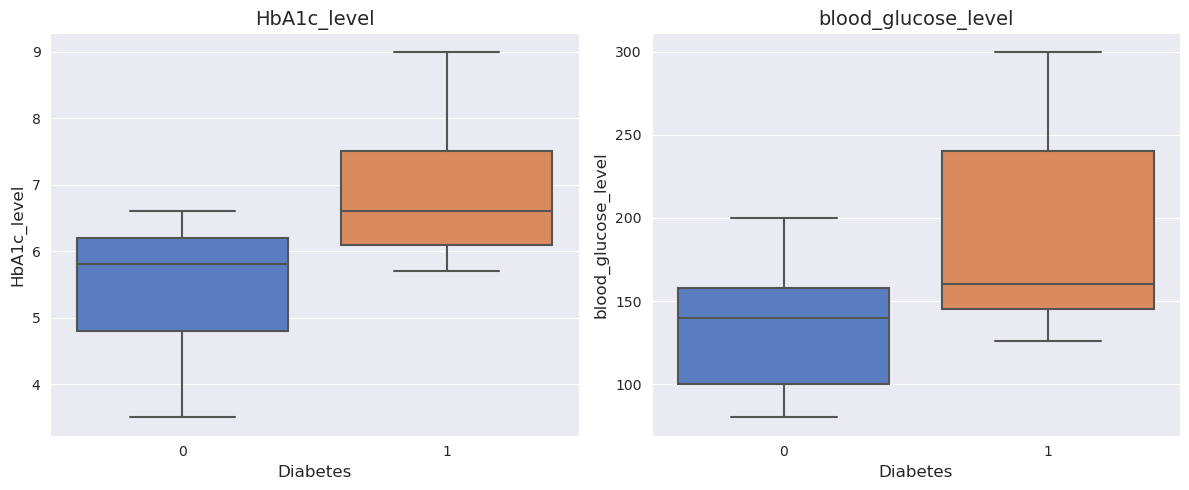

In [88]:
glucose_related = ["HbA1c_level", "blood_glucose_level"]
fig = plt.figure(figsize=(12, 5))

for i, var_name in enumerate(glucose_related):
    ax = fig.add_subplot(1, 2, 1*i+1)
    sns.boxplot(data=df, x="diabetes", y=var_name)
    plt.title(var_name)
    plt.xlabel("Diabetes")
    
fig.tight_layout()

People with high levels of HbA1c and blood glucose are more likely to have diabetes. Indeed, as explained in the introduction, those two measures are the most important for the diagnosis.

## <b><span style="color:#2f3e46">1.2 Categorical features</span></b>

Text(0.5, 0, 'Gender')

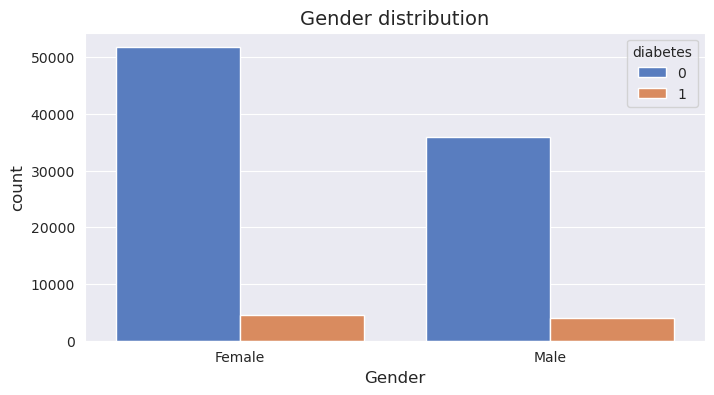

In [89]:
sns.countplot(data=df, x="gender", hue="diabetes")
plt.title("Gender distribution")
plt.xlabel("Gender")

Apparently, gender isn't an important feature, but if we take a better look, we can see men are more likely to have diabetes.

In [90]:
(df.groupby("gender")["diabetes"].sum() / df.groupby("gender")["diabetes"].size()).apply("{:.2%}".format)

gender
Female     7.92%
Male      10.10%
Name: diabetes, dtype: object

Text(0.5, 0, 'Smoking history')

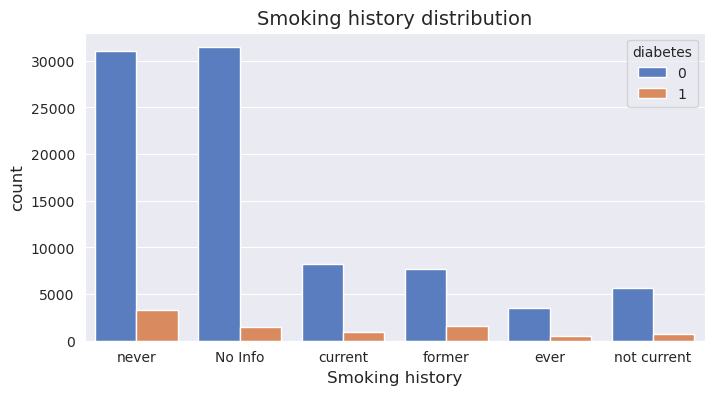

In [91]:
sns.countplot(data=df, x="smoking_history", hue="diabetes")
plt.title("Smoking history distribution")
plt.xlabel("Smoking history")

This feature is imbalanced too. Let's normalize the values and see them in a pie chart.

Text(0, 0.5, '')

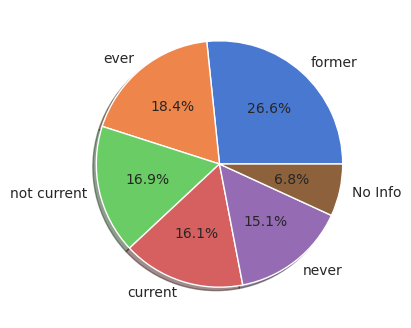

In [92]:
(df.groupby("smoking_history")["diabetes"].sum() / df.groupby("smoking_history").size()).sort_values(ascending=False).plot.pie(shadow=True, autopct="%1.1f%%")
plt.ylabel("")

We can also redefine the <b>smoking_history</b> feature to help our models to find better relationships.

In [93]:
def redef_SH(smoking_status):
    if smoking_status in ["never", "No Info"]:
        return "non-smoker"
    elif smoking_status == "current":
        return "current"
    elif smoking_status in ["former", "ever", "not current"]:
        return "past smoker"

In [94]:
df["smoking_history"] = df["smoking_history"].apply(redef_SH)
df["smoking_history"].unique()

array(['non-smoker', 'current', 'past smoker'], dtype=object)

<Axes: >

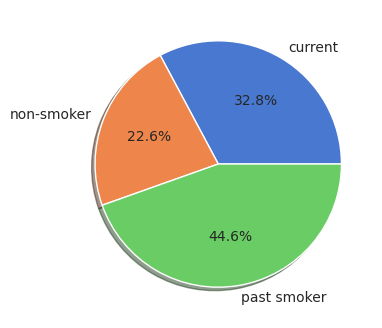

In [95]:
(df.groupby("smoking_history")["diabetes"].sum() / df.groupby("smoking_history").size()).plot.pie(shadow=True, autopct="%1.1f%%")

## <b><span style="color:#2f3e46">1.3 Correlation</span></b>

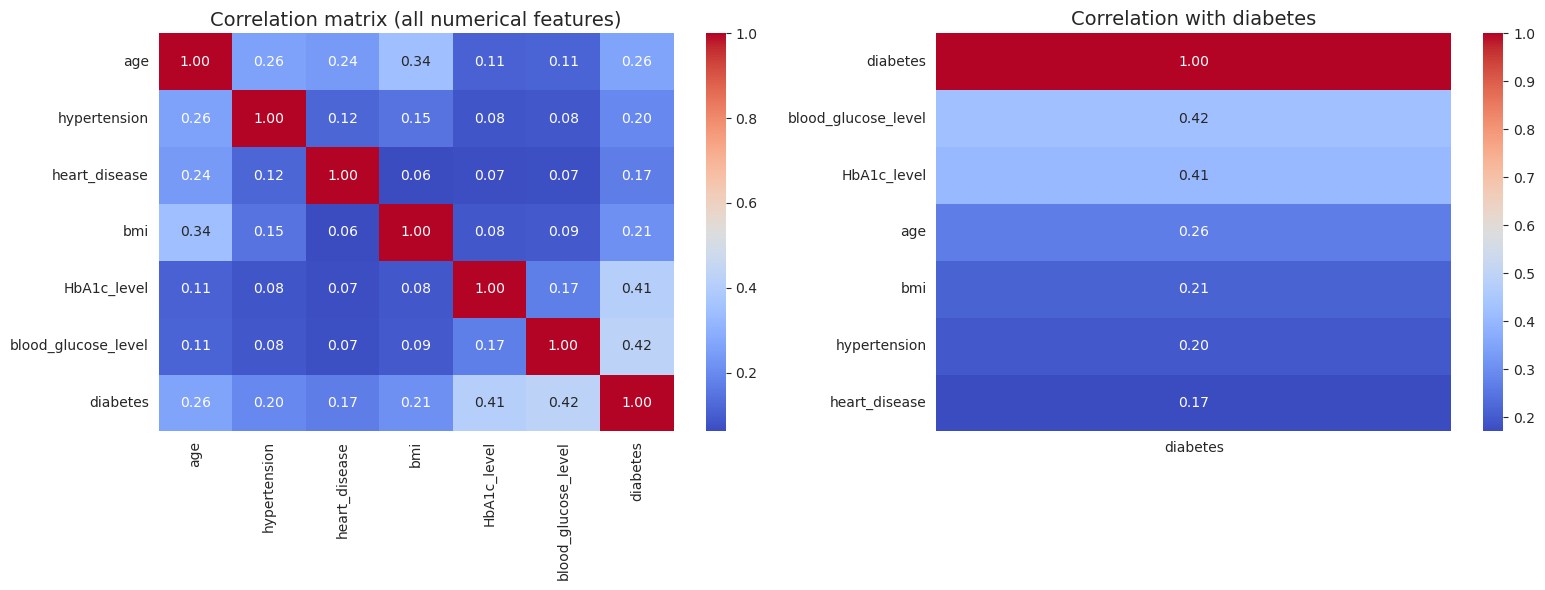

In [96]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation matrix (all numerical features)")

corr_diabetes = df.corr()["diabetes"].sort_values(ascending=False).to_frame()
plt.subplot(1, 2, 2)
sns.heatmap(corr_diabetes, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation with diabetes")

fig.tight_layout()

We can see that the correlation is either very weak or weak between the numerical features. But <b>blood_glucose_level</b> and <b>HbA1c_level</b> are the most important as said before.

## <b><span style="color:#2f3e46">1.4 Target</span></b>

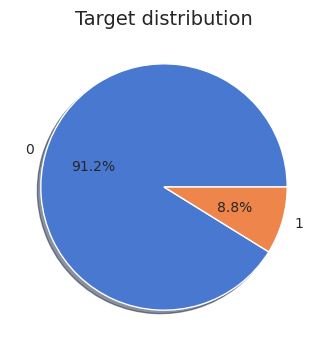

In [97]:
plt.pie(df["diabetes"].value_counts(), labels=df["diabetes"].unique(), shadow=True, autopct="%1.1f%%")
plt.title("Target distribution")

plt.show()

Unfortunately the target is very imbalanced, with only 9% positive cases. In cases like that, it's essential to balance the data to ensure the model doesn't get biased toward the majority class. 

For this purpose, we'll use SMOTE and RandomUnderSampler to balance the dataset.

# <b><span style="color:#2f3e46">2 Preprocessing</span></b>

In [98]:
# Split the DataFrame into X and y
X = df.drop("diabetes", axis=1).copy()
y = df["diabetes"].copy()

## <b><span style="color:#2f3e46">2.1 Encoding and scaling</span></b>

In [99]:
# Get numerical and categorical features
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# Pipeline
num_pipe = Pipeline(steps=[("scaler", StandardScaler())])
cat_pipe = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

# ColumnTransformer
transformer = ColumnTransformer(transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features)],
        remainder="passthrough")

# Apply it all
X_transformed = transformer.fit_transform(X)
print("X shape:", X.shape)

X shape: (96128, 8)


## <b><span style="color:#2f3e46">2.2 Sampling</span></b>

In [100]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

# Pipeline
sampling_pipe = imbPipeline(steps=[
        ("over", over),
        ("under", under)])

# Apply the sampling technique
X_sampled, y_sampled = sampling_pipe.fit_resample(X_transformed, y)

## <b><span style="color:#2f3e46">2.3 Split</span></b>

In [101]:
seed = 42
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=seed)

# <b><span style="color:#2f3e46">3 Model selection</span></b>

## <b><span style="color:#2f3e46">3.1 Cross-validation</span></b>

In [102]:
# Classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=seed),
    "DecisionTree": DecisionTreeClassifier(random_state=seed),
    "AdaBoost": AdaBoostClassifier(random_state=seed),
    "RandomForest": RandomForestClassifier(random_state=seed), 
    #"SVC": SVC(random_state=seed, kernel="rbf", probability=True), # SVC takes too long to run
    "LGBM": LGBMClassifier(random_state=seed),
    "CatBoost": CatBoostClassifier(random_state=seed, verbose=False, thread_count=4)
}

Since false positives and false negatives are almost equally costly, we should use F1 Score (or Recall, if we want to ensure diabetic individuals are correctly identified for necessary interventions) to evaluate the models.

In [103]:
# Create a DataFrame to store the results
cross_val_results = pd.DataFrame({"Classifier": classifiers.keys(), "F1 Score": np.empty(len(classifiers)), "Running time (s)": np.empty(len(classifiers))})

folds = 10
i = 0
print("Running time: ")
print(30*"-")
for key, classifier in classifiers.items():
    
    # Start timer
    t0 = time.time()
    
    # 10 fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cross_val_scores = cross_val_score(classifier, X_train, y_train, scoring="f1", cv=cv)
    cross_val_results.iloc[i, 1] = cross_val_scores.mean()
    
    # Stop timer
    t1 = time.time()
    cross_val_results.iloc[i, 2] = np.round(t1 - t0, 2)
    
    # Print running time
    print(f"{key}:", cross_val_results.iloc[i, 2], "s")
    
    # Next row
    i += 1

Running time: 
------------------------------
LogisticRegression: 0.89 s
DecisionTree: 0.62 s
AdaBoost: 7.03 s
RandomForest: 16.78 s
LGBM: 6.03 s
CatBoost: 57.69 s


In [104]:
cross_val_results

,Classifier,F1 Score,Running time (s)
0,LogisticRegression,0.835,0.890
1,DecisionTree,0.836,0.620
2,AdaBoost,0.871,7.030
3,RandomForest,0.861,16.780
4,LGBM,0.872,6.030
5,CatBoost,0.868,57.690


AdaBoost, LGBM, and CatBoost are the best models for prediction. We can tune their hyperparameters now.

## <b><span style="color:#2f3e46">3.2 Tuning hyperparameters</span></b>

In [105]:
# Best models
best_classifiers = {
    "AdaBoost": AdaBoostClassifier(random_state=seed),
    "LGBM": LGBMClassifier(random_state=seed),
    "CatBoost": CatBoostClassifier(random_state=seed, verbose=False, thread_count=4)
}

# Grid to search for
grid = {
    "AdaBoost": {"n_estimators": [50, 100, 150, 200],
                 "learning_rate": [0.05, 0.1, 0.15]},
    "LGBM": {"n_estimators": [50, 100, 150, 200],
             "max_depth": [4, 8, 12],
             "learning_rate": [0.05, 0.1, 0.15]},
    "CatBoost": {"iterations": [100, 200, 300],
                 "learning_rate": [0.05, 0.1, 0.15],
                 "depth": [4, 6, 8]}
}

In [106]:
# Create a DataFrame to store the results
grid_search_results = pd.DataFrame({"Classifier": best_classifiers.keys(), "Score": np.empty(len(best_classifiers)), "Running time (s)": np.empty(len(best_classifiers))})

# Dict to store the best parameters
clf_best_params = best_classifiers.copy()

i = 0

print("Training time")
print(30*"-")
for key, classifier in best_classifiers.items():
    # Start timer
    t0 = time.time()

    # Create GridSearch
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], scoring="f1", cv=5)

    # Train the model
    clf.fit(X_train, y_train)
    grid_search_results.iloc[i, 1] = clf.score(X_train, y_train)

    # Store the best parameters
    clf_best_params[key] = clf.best_params_

    # Stop timer
    t1 = time.time()
    grid_search_results.iloc[i, 2] = np.round(t1 - t0, 2)

    # Print training time
    print(f"{key}:", grid_search_results.iloc[i, 2], "s")
    i += 1

Training time
------------------------------
AdaBoost: 94.04 s
LGBM: 107.06 s
CatBoost: 173.37 s


In [107]:
grid_search_results

,Classifier,Score,Running time (s)
0,AdaBoost,0.872,94.040
1,LGBM,0.887,107.060
2,CatBoost,0.878,173.370


In [108]:
clf_best_params

{'AdaBoost': {'learning_rate': 0.15, 'n_estimators': 200},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150},
 'CatBoost': {'depth': 4, 'iterations': 100, 'learning_rate': 0.15}}

# <b><span style="color:#2f3e46">4 Modeling</span></b>

To ensure we get the best from all models, we can use the VotingClassifier to improve the overall performance and robustness of the final model.

In [109]:
ensemble = [
    ("AdaBoost", AdaBoostClassifier(**clf_best_params["AdaBoost"], random_state=seed)),
    ("LGBM", LGBMClassifier(**clf_best_params["LGBM"], random_state=seed)),
    ("CatBoost", CatBoostClassifier(**clf_best_params["LGBM"], random_state=seed, verbose=False, thread_count=4))
]

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3531
           1       0.90      0.84      0.87      1728

    accuracy                           0.92      5259
   macro avg       0.91      0.90      0.90      5259
weighted avg       0.92      0.92      0.92      5259



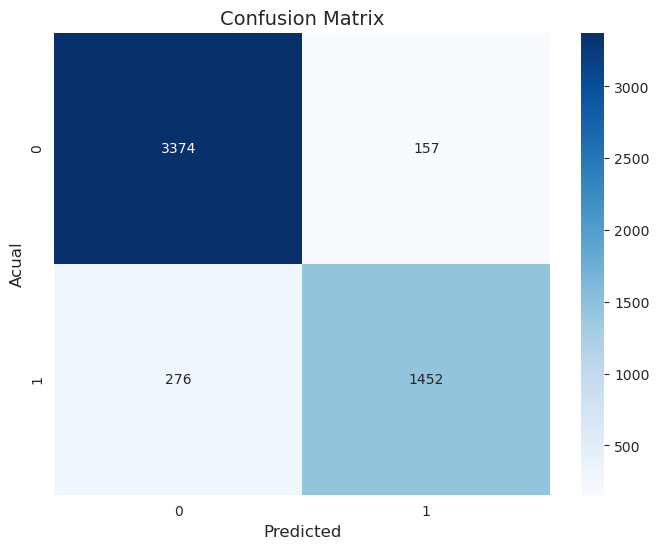

In [110]:
# Soft voting did better
voting_clf = VotingClassifier(ensemble, voting="soft")
voting_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Acual")
plt.show()

<div style="padding:15px; text-align:left; border-radius:10px; background-color:#c0d6df">
<p>The accuracy achieved indicates that our ensemble model correctly classified around 92% of all cases in the test set.</p>
<b><span style="font-size: 16px">Class 0 (non-diabetes):</span></b>
<ul>
    <li>A precision of 0.92 means that among all instances where the model predicted non-diabetes, 92% were indeed non-diabetes</li>
    <li>A recall of 0.96 means that the model correctly identified 96% of all actual non-diabetes cases in the dataset</li>
</ul>

<b><span style="font-size: 16px">Class 1 (diabetes):</span></b>
<ul>
    <li>The precision for class 1 is high too (0.90). This means that the model predicted diabetes correctly 90% of the time</li>
    <li>The recall is a bit lower (0.84), which means that the model correctly identified 84% of all actual diabetes cases in the dataset</li>
</ul>
</div>

## <b><span style="color:#2f3e46">4.1 Feature importance</span></b>

The feature importance provides insight into which features are most influential in predicting diabetes.

We can use the attribute <code>feature_importance_</code> to extract these values from each model.

In [111]:
# Retrieve feature names
onehot_columns = transformer.named_transformers_["cat"].get_feature_names_out(cat_features).tolist()
feature_names = num_features + onehot_columns

# Create dataframe to store each model's feature importance
adaboost_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": voting_clf.estimators_[0].feature_importances_}).sort_values("Importance", ascending=False)
lgbm_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": voting_clf.estimators_[1].feature_importances_}).sort_values("Importance", ascending=False)
catboost_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": voting_clf.estimators_[2].feature_importances_}).sort_values("Importance", ascending=False)

# Create dict to loop
models = {"AdaBoost": adaboost_importance_df, 
          "LGBM": lgbm_importance_df, 
          "CatBoost": catboost_importance_df}

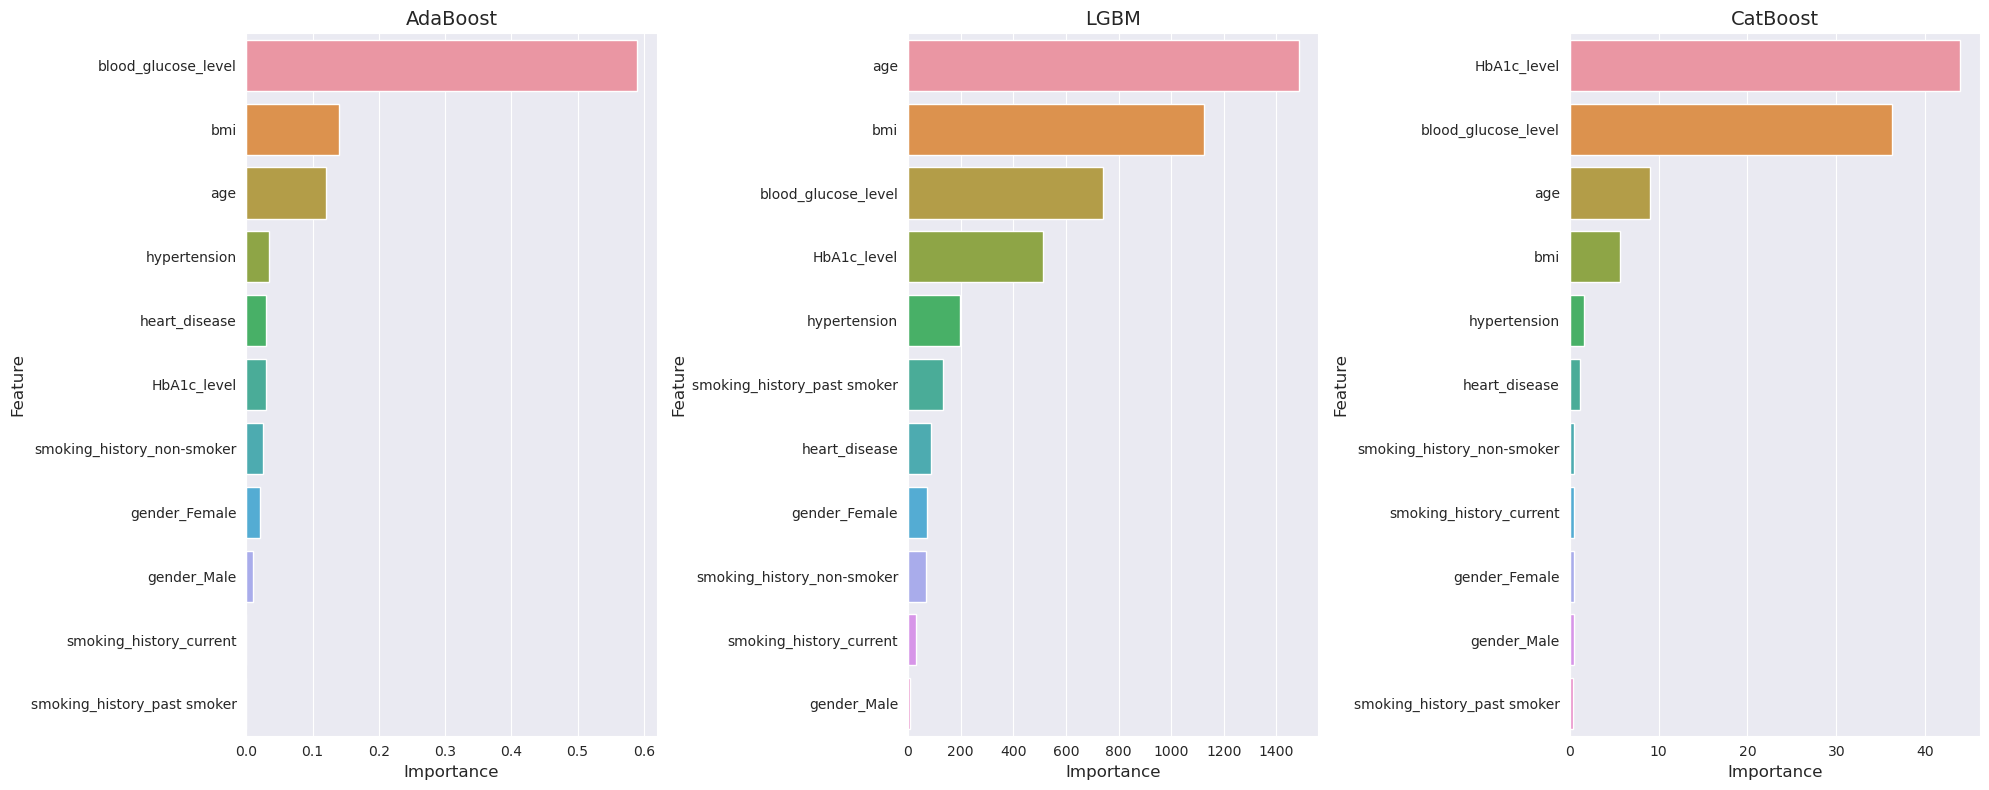

In [115]:
fig = plt.figure(figsize=(20,8))

i = 0
for key, model in models.items():
    fig.add_subplot(1, 3, 1*i+1)
    sns.barplot(data=model, x="Importance", y="Feature")
    plt.title(key)
    
    i += 1
    
fig.tight_layout()

As the plots show, each model considers a feature more or less influential than the other. But, if we look at the top 3 for each model, all three find the features __blood_glucose_level__, __bmi__, and __age__ important when predicting diabetes. We saw, in fact, that those three features (__HbA1c_level__ as well) are the most critical factors when diagnosing diabetes. 

Therefore, the results do align well with the literature about risk factors for diabetes.